### The value iteration, policy iteration and Q learning algorithm used for this assignment where adapted from codes that can be found at:
#### Value iteration & Policy Iteration: https://medium.com/@annishared/searching-for-optimal-policies-in-python-an-intro-to-optimization-7182d6fe4dba
####  Q-Learning :  https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

In [28]:
import gym
import numpy as np
import time
import matplotlib.pyplot as plt

In [17]:
env1 = gym.make("Taxi-v3").env

env1.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [6]:
env2 = gym.make("Taxi-v4").env
env2.render()

+-----------------------------+
|R: : : : | : : : :G: : : : : |
| : : : : | : : : : : : : : : |
| : : : : | : : : : : : : : : |
| : : : : : : : | : : : | : : |
| : | : :Y: : : | : : : | : :B|
| : | : : : : : : : : : | : : |
| : | : : : : : : : : : | : : |
| : | : : : : : : : : : : : : |
|O: : : : : : | : : : : : : : |
| : : : : : : | : :P: : : : : |
| : : : : : : | : : : : : : : |
| : : : : : : : : : : | : : : |
| : : : | : : : : : : | : : : |
| : : : | : : : : : : | : : : |
| : :M: | : : : : : : | :C: : |
+-----------------------------+



### Helper functions 

In [16]:
def taxi_route(policy, s1, env):
    env.s=s1
    env.render()
    while policy[s1].tolist()!=[0., 0., 0., 0., 0., 1.]:
        a=np.argmax(policy[s1])
        print(a, policy[s1])
        #print(policy_q_2[s1], policy[s1])
        next_state, reward, done, info = env.step(a)
        s1= next_state  
        env.s=s1
        env.render()
        
    a = np.argmax(policy[s1])
    next_state, reward, done, info = env.step(a)
    s1= env.P[s1][a][0][1]
    env.s=s1
    env.render()

In [17]:
def encode2(taxi_row, taxi_col, pass_loc, dest_idx):
    # (15) 15, 9, 8
    i = taxi_row
    i *= 15
    i += taxi_col
    i *= 9
    i += pass_loc
    i *= 8
    i += dest_idx
    return i

def decode2(i):
    out = []
    out.append(i % 8)
    i = i // 8
    out.append(i % 9)
    i = i // 9
    out.append(i % 15)
    i = i // 15
    out.append(i)
    assert 0 <= i < 15
    return out[::-1]

def encode1(taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i
def decode1(i):
    out = []
    out.append(i % 4) #dest
    i = i // 4 
    out.append(i % 5) #pass_loc
    i = i // 5 
    out.append(i % 5) #col
    i = i // 5 
    out.append(i)   #row
    assert 0 <= i < 5
    return out[::-1]

In [18]:
def visualize_policy(policy, len_row, len_col):
    visu = []
    for i in range(len_row):
        visu.append("|")
        for j in range(len_col):
            s = encode2(i,j,2,1)
            a = np.argmax(policy[s])
            if a==0:
                visu[i] = visu[i] + 's|'
            if a==1:
                visu[i] = visu[i] + 'n|'
            if a==2:
                visu[i] = visu[i] + 'e|'
            if a==3:
                visu[i] = visu[i] + 'w|'
            if a==4:
                visu[i] = visu[i] + 'p|'
            if a==5:
                visu[i] = visu[i] + 'd|'
    return(visu, s)

        

In [19]:
def average_reward_route(policy, s1, env):
    env.s=s1
    #env.render()
    total_reward = 0
    i=0
    converge = True
    done = False
    while not done:
        i+=1
        a = np.argmax(policy[s1])
        next_state, reward, done, info = env.step(a)
        s1= next_state
        total_reward +=reward
        env.s=s1
       # env.render()
        if i>500:
            converge = False
            break
            
    
    a = np.argmax(policy[s1])
    next_state, reward, done, info = env.step(a)
    s1= next_state
    env.s=s1
    #env.render()
    total_reward +=reward
    return(total_reward, converge)


In [20]:
def compute_average_reward(policy, env):
    average_reward = 0
    count_cv = 0
    for s in range(env.nS):
        
        a, cv =average_reward_route(policy,  s, env)
        if cv == True:
            count_cv+=1
            average_reward+=a
    return(average_reward/(count_cv), env.nS-count_cv)

In [78]:
def vizu_reward(P, env):
    average_rewards=[]
    count_divergence=[]
    vizu = []
    if len(P)<100:
        for i in range(len(P)-1):
            policy = P[i+1]
            average_reward, count_dv=compute_average_reward(policy, env)
            average_rewards.append(average_reward)
            count_divergence.append(count_dv)
            vizu.append(average_reward-0.1*count_dv)
        return(vizu, average_rewards, count_divergence)
    else:
        for i in range(0, len(P)-1,10 ):
            policy = P[i+1]
            average_reward, count_dv=compute_average_reward(policy, env)
            average_rewards.append(average_reward)
            count_divergence.append(count_dv)
            vizu.append(average_reward-0.1*count_dv)
        return(vizu, average_rewards, count_divergence)

### Policy iteration
https://medium.com/@annishared/searching-for-optimal-policies-in-python-an-intro-to-optimization-7182d6fe4dba

In [2]:
def policy_eval(policy, env, discount_factor=1.0, theta=0.01):
    # Initialize thel value function
    V = np.zeros(env.nS)
    # While our value function is worse than the threshold theta
    while True:
        # Keep track of the update done in value function
        delta = 0
        # For each state, look ahead one step at each possible action and next state
        for s in range(env.nS):
            v = 0
            # The possible next actions, policy[s]:[a,action_prob]
            for a, action_prob in enumerate(policy[s]): 
                # For each action, look at the possible next states, 
                for prob, next_state, reward, done in env.P[s][a]: # state transition P[s][a] == [(prob, nextstate, reward, done), ...]
                    # Calculate the expected value function
                    #print(reward, V[next_state], next_state)
                    v += action_prob * prob * (reward + discount_factor * V[next_state]) # P[s, a, s']*(R(s,a,s')+γV[s'])
                    # How much our value function changed across any states .  
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function update is below a threshold
        if delta < theta:
            break
        
    return np.array(V)

In [3]:

def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=0.99, beta=0.01):
    # Initiallize a policy arbitarily
    policy = np.ones([env.nS, env.nA]) / env.nA #pick action randomly
    i=0
    P=[policy]
    iteration = []
    iteration_time=[]
    policy_change=[]
    innovation=[]
    Values=[]
    while i<10000:
        t0=time.time()
        iteration.append(i)
        sigma=0
        
        print(i)
        # Compute the Value Function for the current policy
        V=policy_eval_fn(policy, env, discount_factor)
        Values.append(V)
        # Will be set to false if we update the policy
        policy_stable = True
        
        # Improve the policy at each state
        for s in range(env.nS):
            # The best action we would take under the currect policy
            chosen_a = np.argmax(policy[s])
            # Find the best action by one-step lookahead
            action_values = np.zeros(env.nA)
            for a in range(env.nA):
                for prob, next_state, reward, done in env.P[s][a]:
                    action_values[a] += prob * (reward + discount_factor * V[next_state])
            best_a = np.argmax(action_values)
            
            # Greedily (max in the above line) update the policy
            if chosen_a != best_a:
                policy_stable = False
                sigma+=1
            #sigma += np.mean(np.abs(policy[s]- np.eye(env.nA)[best_a]))
            policy[s] = np.eye(env.nA)[best_a]
        P.append(policy.copy())
        iteration_time.append(time.time()-t0)
        policy_change.append(sigma)
        # Until we've found an optimal policy. Return it
        if sigma<beta:
            return policy, V, P, iteration, iteration_time, policy_change, Values
        i+=1


In [14]:
policy_pi_2, V_pi_2, P_pi_2, iterations_pi_2, iteration_time_pi_2, policy_change_pi_2, Values_pi_2 = policy_improvement(env2, discount_factor=0.95)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


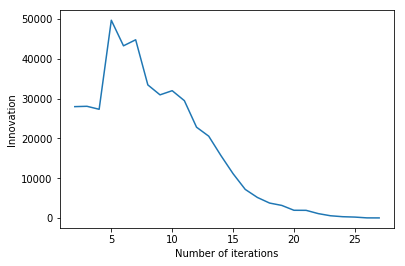

In [698]:
innovation_pi_2=[]
for i in range(1, len(Values_pi_2)-1):
    innovation_pi_2.append(np.sum(np.abs(Values_pi_2[i]-Values_pi_2[i-1])))


b = np.arange(2,len(innovation_pi_2))
plt.plot(b, innovation_pi_2[2:])
plt.ylabel('Innovation')
plt.xlabel('Number of iterations')
plt
plt.show()

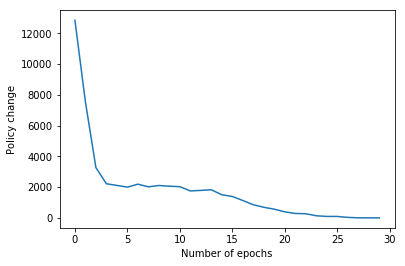

In [693]:
b = np.arange(len(policy_change_pi_2))
plt.plot(b, policy_change_pi_2 )
plt.ylabel('Policy change')
plt.xlabel('Number of epochs')
plt.show()

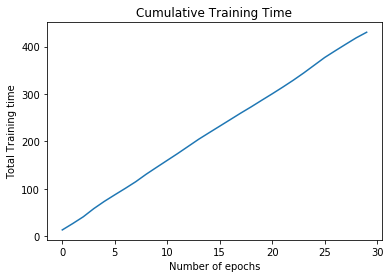

In [691]:
b = np.arange(len(iteration_time_pi_2))
plt.plot(b, np.cumsum(iteration_time_pi_2 ))
plt.ylabel('Total Training time')
plt.xlabel('Number of epochs')
plt.title('Cumulative Training Time')
plt.show()


#### Reward

In [22]:
vizu_pi_2, av_pi_2, ct_dv_pi_2 = vizu_reward(P_pi_2, env2) 

In [29]:
print(ct_dv_pi_2)

[14485, 14127, 13833, 13436, 13065, 12039, 11356, 10464, 9629, 8667, 7516, 6402, 5235, 4073, 3109, 2303, 1832, 1389, 993, 678, 473, 249, 147, 65, 24, 0, 0, 0, 0, 0]


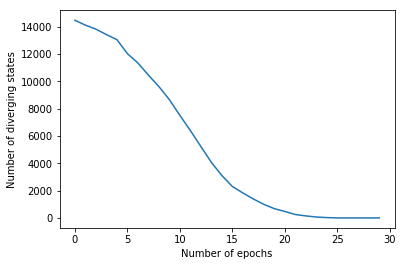

In [30]:
b = np.arange(len(ct_dv_pi_2))
plt.plot(b, ct_dv_pi_2 )
plt.ylabel('Number of diverging states')
plt.xlabel('Number of epochs')
plt.show()

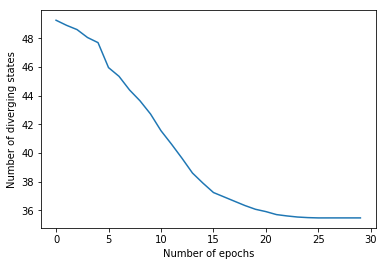

In [32]:
b = np.arange(len( av_pi_2))
plt.plot(b,  av_pi_2 )
plt.ylabel('Number of diverging states')
plt.xlabel('Number of epochs')
plt.show()

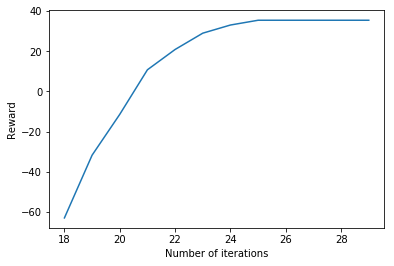

In [34]:
b = np.arange(18,len(vizu_pi_2))
plt.plot(b, vizu_pi_2[18:] )
plt.ylabel('Reward')
plt.xlabel('Number of iterations')
plt.show()

#### Vizualization of the policy

In [629]:
visu_2, s0 = visualize_policy(policy_pi_2, 15, 15)
env2.s = s0
env2.render()
for i in range(len(visu_2)):
    print(visu_2[i])

+-----------------------------+
|R: : : : | : : : :G: : : : : |
| : : : : | : : : : : : : : : |
| : : : : | : : : : : : : : : |
| : : : : : : : | : : : | : : |
| : | : :Y: : : | : : : | : :B|
| : | : : : : : : : : : | : : |
| : | : : : : : : : : : | : : |
| : | : : : : : : : : : : : : |
|O: : : : : : | : : : : : : : |
| : : : : : : | : :P: : : : : |
| : : : : : : | : : : : : : : |
| : : : : : : : : : : | : : : |
| : : : | : : : : : : | : : : |
| : : : | : : : : : : | : : : |
| : :M: | : : : : : : | :C: : |
+-----------------------------+
  (Pickup)
|s|s|s|s|s|s|s|s|s|s|s|s|s|s|s|
|s|s|s|s|s|s|s|s|s|s|s|s|s|s|s|
|s|s|s|s|s|s|s|s|s|s|s|s|s|s|s|
|s|s|s|s|s|s|s|s|s|s|s|s|s|s|s|
|s|s|s|s|s|s|s|s|s|s|s|s|s|s|s|
|s|s|s|s|s|s|s|s|s|s|s|s|s|s|s|
|s|s|s|s|s|s|s|s|s|s|s|s|s|s|s|
|s|s|s|s|s|s|s|w|w|w|w|w|w|w|w|
|p|w|w|w|w|w|w|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|s|s|s|s|n|n|n|n|
|n|n|n|n|n|n|n|w|w|w|w|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|

### Value iteration 
https://medium.com/@annishared/searching-for-optimal-policies-in-python-an-intro-to-optimization-7182d6fe4dba

In [36]:
import time
def value_iteration(env, theta=0.0000000001, discount_factor=0.3):
    # Look ahead one step at each possible action and next state (full backup)  
    innovation = []
    iteration = []
    iteration_time=[]
    P=[]
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    V = np.zeros(env.nS)
    i=0
    while True:
        t0=time.time()
        iteration.append(i)
        i+=1
        # Stopping condition
        delta = 0
        # Update each state...

        policy = np.zeros([env.nS, env.nA])
        for s in range(env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            best_action = np.argmax(A)
            policy[s, best_action] = 1.0
            # Calculate delta across all states seen so far
            #delta = max(delta, np.abs(best_action_value - V[s]))
            delta += np.abs(best_action_value - V[s])

            # Update the value function
            V[s] = best_action_value
            env.s=s
        P.append(policy)

        # Check if we can stop 
        innovation.append(delta)
        iteration_time.append(time.time()-t0)
        if delta < theta:
            break
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0
    P.append(policy)
    return policy, V, innovation, iteration, iteration_time, P

In [37]:
policy_vi_2, V_vi_2, innovation_vi_2, iteration_vi_2, iteration_time_vi_2 , P_vi_2= value_iteration(env2, discount_factor=0.99)

In [70]:
VI_gamma_95=value_iteration(env2, discount_factor=0.95)

#### Plot Innovation Curve

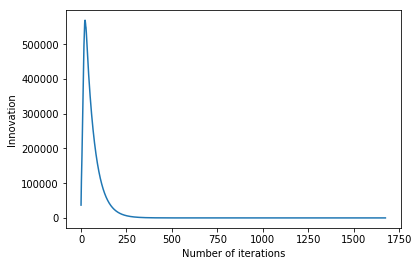

In [40]:
b = np.arange(len(innovation_vi_2))
plt.plot(b, innovation_vi_2 )
plt.ylabel('Innovation')
plt.xlabel('Number of iterations')
plt.show()

#### Plot iteration time

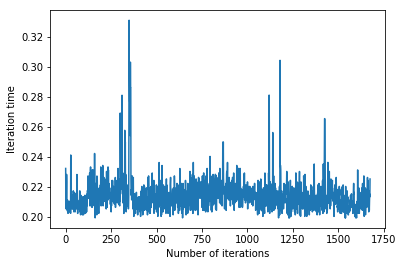

In [625]:
b = np.arange(len(iteration_time_vi_2))
plt.plot(b, iteration_time_vi_2 )
plt.ylabel('Iteration time')
plt.xlabel('Number of iterations')
plt.show()

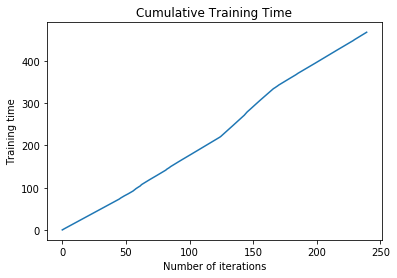

In [102]:
b = np.arange(len(iteration_time_vi_2))
plt.plot(b, np.cumsum(iteration_time_vi_2 ))
plt.ylabel('Training time')
plt.xlabel('Number of iterations')
plt.title('Cumulative Training Time')
plt.show()

#### let's vizualize the route the taxi will take for a given initial state

In [600]:
visu_2, s0 = visualize_policy(policy_vi_2, 15, 15)
env2.s = s0
env2.render()
for i in range(len(visu_2)):
    print(visu_2[i])

+-----------------------------+
|R: : : : | : : : :G: : : : : |
| : : : : | : : : : : : : : : |
| : : : : | : : : : : : : : : |
| : : : : : : : | : : : | : : |
| : | : :Y: : : | : : : | : :B|
| : | : : : : : : : : : | : : |
| : | : : : : : : : : : | : : |
| : | : : : : : : : : : : : : |
|O: : : : : : | : : : : : : : |
| : : : : : : | : :P: : : : : |
| : : : : : : | : : : : : : : |
| : : : : : : : : : : | : : : |
| : : : | : : : : : : | : : : |
| : : : | : : : : : : | : : : |
| : :M: | : : : : : : | :C: :_|
+-----------------------------+
  (Dropoff)
|s|s|s|s|s|e|e|e|e|d|w|w|w|w|w|
|s|s|s|s|s|n|n|n|n|n|n|n|n|n|n|
|s|s|s|s|s|n|n|n|n|n|n|n|n|n|n|
|e|e|e|e|e|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n

#### Comparaison with policy_vi

In [650]:
visu_2, s0 = visualize_policy(policy_vi_2, 15, 15)
for i in range(len(visu_2)):
    print(visu_2[i])
print( "------------------------------")
visu_3, s0 = visualize_policy(policy_pi_2, 15, 15)
for i in range(len(visu_3)):
    print(visu_3[i])
env2.s=s0
env2.render()

|s|s|s|s|s|s|s|s|s|s|s|s|s|s|s|
|s|s|s|s|s|s|s|s|s|s|s|s|s|s|s|
|s|s|s|s|s|s|s|s|w|w|w|w|w|w|w|
|e|e|s|s|s|s|s|s|s|s|s|s|n|n|n|
|n|n|e|e|p|w|w|w|s|s|s|s|n|n|n|
|n|n|n|n|n|n|n|n|w|w|w|w|s|s|s|
|n|n|n|n|n|n|n|n|n|n|n|n|s|s|s|
|s|s|n|n|n|n|n|n|n|n|n|n|w|w|w|
|e|e|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
|n|n|n|n|n|n|n|n|n|n|n|n|n|n|n|
------------------------------
|s|s|s|s|s|s|s|s|s|s|s|s|s|s|s|
|s|s|s|s|s|s|s|s|s|s|s|s|s|s|s|
|s|s|s|s|s|s|s|s|w|w|w|w|w|w|w|
|e|e|s|s|s|s|s|s|s|s|s|s|n|n|n|
|e|n|e|e|p|w|w|w|s|s|s|s|n|n|n|
|e|n|e|e|n|n|n|n|w|w|w|w|s|s|s|
|e|n|e|e|n|n|n|n|n|n|n|n|s|s|s|
|s|s|e|e|n|n|n|n|n|n|n|n|w|w|w|
|e|e|e|e|n|n|n|n|n|n|n|n|n|n|n|
|e|e|e|e|n|n|n|n|n|n|n|n|n|n|n|
|e|e|e|e|n|n|n|n|n|n|n|n|n|n|n|
|e|e|e|e|n|n|n|n|n|n|n|n|n|n|n|
|e|e|e|n|n|n|n|n|n|n|n|n|n|n|n|
|e|e|e|n|n|n|n|n|n|n|n|n|n|n|n|
|e|e|e|n|n|n|n|n|n|n|n|n|n|n|n|
+--------

###  average reward function number of iterations for policy iteration

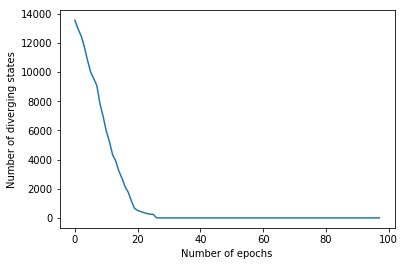

In [63]:
b = np.arange(len(ct_dv_vi21))
plt.plot(b, ct_dv_vi21 )
plt.ylabel('Number of diverging states')
plt.xlabel('Number of epochs')
plt.show()

In [54]:
vizu_vi_21, av_vi_21, ct_dv_vi21 = vizu_reward(P_vi_2[0:99], env2) 

[22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45
 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69
 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93
 94 95 96 97]


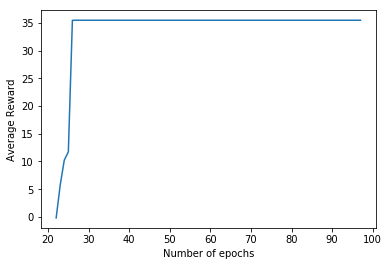

In [69]:
b = np.arange(22,len(vizu_vi_21))
print(b)
plt.plot(b, vizu_vi_21[22:] )
plt.ylabel('Average Reward')
plt.xlabel('Number of epochs')
plt.show()

In [92]:
vizu_vi_2_95, av_vi_2_95, ct_dv_vi2_95 = vizu_reward(VI_gamma_95[5][0:50], env2) 

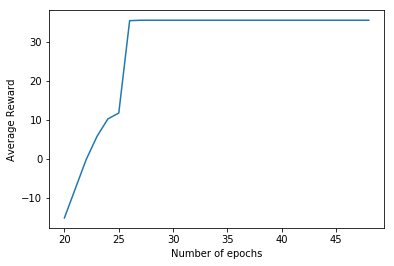

In [96]:
b = np.arange(20,len(vizu_vi_2_95))
plt.plot(b, vizu_vi_2_95[20:])
plt.ylabel('Average Reward')
plt.xlabel('Number of epochs')
plt.show()

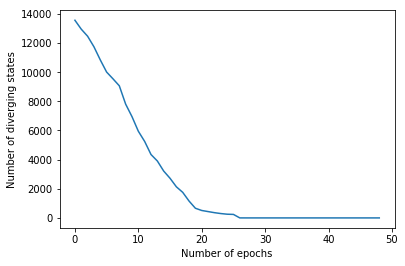

In [95]:
b = np.arange(len(ct_dv_vi2_95))
plt.plot(b, ct_dv_vi2_95 )
plt.ylabel('Number of diverging states')
plt.xlabel('Number of epochs')
plt.show()

#### tuning of gamma 

In [548]:
gammas = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 0.95, 0.99]
policy_vi2_gamma=[]
V_vi2_gamma=[]
iteration_time_vi_2_gamma=[]
iteration_vi_2_gamma=[]
innovation_vi_2_gamma=[]
for gamma in gammas:
    print(gamma)
    policy_vi_2, V_vi_2, innovation_vi_2, iteration_vi_2, iteration_time_vi_2 , P_vi_2= value_iteration(env2, discount_factor=gamma)
    policy_vi2_gamma.append(policy_vi_2)
    V_vi2_gamma.append(V_vi_2)
    iteration_time_vi_2_gamma.append(iteration_time_vi_2)
    iteration_vi_2_gamma.append(iteration_vi_2)
    innovation_vi_2_gamma.append(innovation_vi_2)
    
    

0.05
0.1
0.2
0.3
0.4
0.5
0.7
0.9
0.95
0.99


#### Vizualization of the route of the taxi for a random initial state

In [516]:
import random as rd
s2=rd.randint(0,16200)
taxi_route(policy_q_2, s2, env2)

+-----------------------------+
|R: : : : | : : : :G: : : : : |
| : : : : | : : : : : : : : : |
| : : : : | : : : : : : : : : |
| : : : : : : : | : : : | : : |
| : | : :Y: : : | : : : | : :B|
| : | : : : : : : : : : | : : |
| : | : : : : : : : : : | : : |
| : | : : : : : : : : : : : : |
|O: : : : : : | : : : : : : : |
| : : : : : : | : :P: : : : : |
| : : : : : : | : : : : : : : |
| : : : : : : : : : : | : : : |
| : : : | : : : : : : | : : : |
| : : : | : : : : : : | : : : |
| : :M: | : : : : : : | :C: : |
+-----------------------------+
  (Dropoff)
0 [1 0 0 0 0 0]
+-----------------------------+
|R: : : : | : : : :G: : : : : |
| : : : : | : : : : : : : : : |
| : : : : | : : : : : : : : : |
| : : : : : : : | : : : | : : |
| : | : :Y: : : | : : : | : :B|
| : | : : : : : : : : : | : : |
| : | : : : : : : : : : | : : |
| : | : : : : : : : : : : : : |
|O: : : : : : | : : : : : : : |
| : : : : : : | : :P: : : : : |
| : : : : : : | : : : : : : : |
| : : : : : : : : : : | : : : |
| : : : | : 

# Q-Learning

In [104]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%pylab inline
import random
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


### The original version of this algorithm was found at: https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

In [166]:


def q_learning(env, alpha = 0.1, gamma = 0.9, epsilon = 0.1, iters = 100001):
    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    t0 = time.time()
    """Training the agent"""

    
    # For plotting metrics
    all_epochs = []
    all_penalties = []
    iterations=[]
    Times=[]

    for i in range(1, iters):
        iterations.append(i)
        state = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values

            next_state, reward, done, info = env.step(action) 
            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1
            Times.append(time.time()-t0)
        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")

            
    print("Training finished.\n"+ str(time.time()-t0))
    return iterations, q_table, Times
    

In [152]:
"""Evaluate agent's performance after Q-learning"""
def evaluate_q_learning(env, q_table):
    total_epochs, total_penalties, total_rewards = 0, 0, 0
    episodes = 100
    Rewards=0
    nb_dv = 0
    for _ in range(episodes):
        state = env.reset()
        epochs, penalties, total_rewards, reward = 0, 0, 0, 0

        done = False
        i=0
        while not done :
            if i>500: 
                nb_dv+=1
                break
            i+=1
            action = np.argmax(q_table[state])
            state, reward, done, info = env.step(action)
            if reward == -10:
                penalties += 1
            
            epochs += 1
            total_rewards += reward
        total_penalties += penalties
        total_epochs += epochs
        Rewards+=total_rewards
    print(f"Results after {episodes} episodes:")
    print(f"Average timesteps per episode: {total_epochs / episodes}")
    print(f"Average penalties per episode: {total_penalties / episodes}")
    print(f"Average rewards per episode: {Rewards / episodes}")
    return(Rewards, nb_dv)

### Tuning of epsilon

In [121]:
epsilons = [0.05, 0.1, 0.2, 0.5, 0.75, 0.9]
R_eps, dv_eps = [], []
for epsilon in epsilons:
    iter_q_1_eps, q_table_1_eps= q_learning(env2,epsilon=epsilon, iters=1000000)
    Reward_1, count_dv_1 = evaluate_q_learning(env2, q_table_1_eps)
    R_eps.append(Reward_1/100)
    dv_eps.append(count_dv_1)

Episode: 999900
Training finished.
12028.882611513138
Results after 100 episodes:
Average timesteps per episode: 27.65
Average penalties per episode: 0.0
Average rewards per episode: 33.35


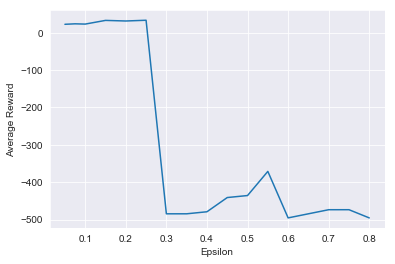

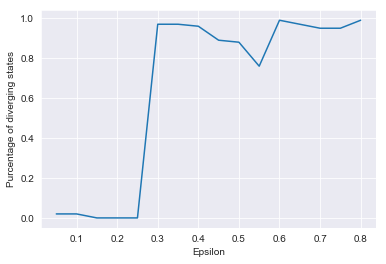

In [165]:
plt.plot(epsilons, R_eps)
plt.ylabel('Average Reward')
plt.xlabel('Epsilon')
plt.show()

plt.plot(epsilons, dv_eps)
plt.ylabel('Purcentage of diverging states')
plt.xlabel('Epsilon')
plt.show()

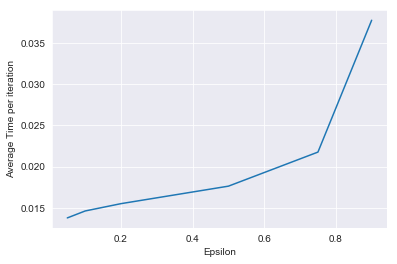

In [144]:
t=np.multiply(times_q_2, 1/10000)
plt.plot(epsilons, t)
plt.ylabel('Average Time per iteration')
plt.xlabel('Epsilon')
plt.show()

### gamma

In [170]:
gammas  = [0.4, 0.6, 0.8, 0.9, 0.99]
R_gamma, dv_gamma = [], []
for gamma in gammas:
    iter_q_2_gamma, q_table_2_gamma, Times_gamma= q_learning(env2,gamma=gamma, iters=10000)
    Reward_2, count_dv_2 = evaluate_q_learning(env2, q_table_2_gamma)
    R_gamma.append(Reward_2/100)
    dv_gamma.append(count_dv_2)

Episode: 9900
Training finished.
99.97519659996033
Results after 100 episodes:
Average timesteps per episode: 409.46
Average penalties per episode: 0.0
Average rewards per episode: -397.87


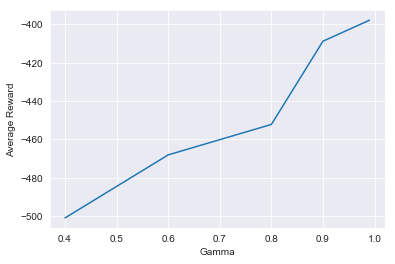

In [179]:
plt.plot(gammas, R_gamma)
plt.ylabel('Average Reward')
plt.xlabel('Gamma')
plt.show()

In [513]:
policy_q_2=[]
v_q_2=[]
for i in range(len(q_table_2)):
    p=np.array([0, 0, 0, 0, 0, 0])
    j=np.argmax(q_table_2[i])
    p[j]=1
    policy_q_2.append(p)
    v_q_2.append(np.max(q_table_2[i]))


### alphas

In [182]:
alphas  = [0.05, 0.1, 0.2, 0.3, 0.5]
R_alpha, dv_alpha = [], []
for alpha in alphas:
    iter_q_2_alpha, q_table_2_alpha= q_learning(env2,alpha=alpha, iters=10000)
    Reward_2, count_dv_2 = evaluate_q_learning(env2, q_table_2_alpha)
    R_alpha.append(Reward_1/100)
    dv_alpha.append(count_dv_2)

Episode: 9900
Training finished.
138.1040358543396


ValueError: too many values to unpack (expected 2)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(alphas, R_alpha)
plt.ylabel('Average Reward per episode')
plt.xlabel('Alpha')
plt.show()

#### Training with the tuned parameters

In [133]:
iter_q_2, q_table_2= q_learning(env2, iters=4000000, alpha=0.1, epsilon=0.1, gamma=0.99)
Reward_2, count_dv_2 = evaluate_q_learning(env2, q_table_2)
R2[9]=Reward_2
dv2[9]=count_dv_2

Episode: 3999900
Training finished.
4044.5595605373383
Results after 100 episodes:
Average timesteps per episode: 26.11
Average penalties per episode: 0.0
Average rewards per episode: 34.89


In [109]:
iterations = [1000, 10000, 50000, 100000, 500000,10000000,20000000,3000000,4000000,5000000]
Rewards_Q_2=[]
Diverge_Q_2=[]
for i in range(len(iterations)):
    iter_q_2, q_table_2= q_learning(env2, iters=iterations[i])
    Reward_2, count_dv_2 = evaluate_q_learning(env2, q_table_2)
    Rewards_Q_2.append(Reward_2)
    Diverge_Q_2.append(count_dv_2)

Episode: 4999900
Training finished.
8295.95809173584
Results after 100 episodes:
Average timesteps per episode: 28.73
Average penalties per episode: 0.0
Average rewards per episode: 32.27


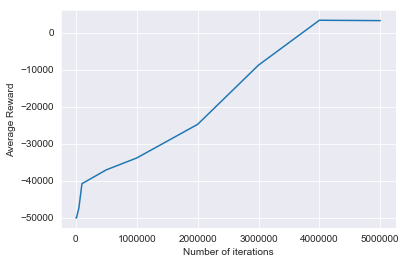

In [119]:
import matplotlib.pyplot as plt
plt.plot(iterations, Rewards_Q_2)
plt.ylabel('Average Reward')
plt.xlabel('Number of iterations')
plt.show()